<a href="https://colab.research.google.com/github/halilyaman/neural_network_implementation/blob/master/NN_architecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### **Import libraries**

In [0]:
import numpy as np
import time
import matplotlib.pyplot as plt

# **Activations class**
This class contains activation functions and derivatives of them. All functions are static in order to use them directly in a neural network. \
X represents the input matrix. \

---
 **sigmoid** \
![Sigmoid Function](https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/Logistic-curve.svg/400px-Logistic-curve.svg.png)

---
**tanh** \
![Tanh Function](https://www.medcalc.org/manual/_help/functions/tanh.png)

---
**ReLU** \
![ReLU Function](https://miro.medium.com/max/400/0*g9ypL5M3k-f7EW85.png)

---
**Leaky Relu** \
![Leaky ReLU](https://1.bp.blogspot.com/-5ymhxBydo8A/XPj_qXK-sWI/AAAAAAAABU4/UjgZ7eChpwsoPa1_bZjvdrzKCsCfQPaJgCLcBGAs/s400/leaking_relu_2.PNG)

In [0]:
class Activations:

  @staticmethod
  def sigmoid(X):

    return 1 / (1 + np.exp(-X))

  @staticmethod
  def linear(X):

    return X

  @staticmethod
  def relu(X):

    return np.maximum(0, X)

  @staticmethod
  def leaky_relu(X):

    return np.maximum(0.01 * X, X)

  @staticmethod
  def tanh(X):

    return np.tanh(X)

  @staticmethod
  def sigmoid_derivative(X):

    X_sigmoid = Activations.sigmoid(X)

    return X_sigmoid * (1 - X_sigmoid)

  @staticmethod
  def relu_derivative(X):
    
    derivatives = np.zeros(X.shape)

    for i, rows in enumerate(X):

      for j, v in enumerate(rows):

        if v < 0:
          derivatives[i, j] = 0
        else:
          derivatives[i, j] = 1

    return derivatives

  @staticmethod
  def leaky_relu_derivative(X):
    
    derivatives = np.zeros(X.shape)

    for i, rows in enumerate(X):

      for j, v in enumerate(rows):

        if v < 0:
          derivatives[i, j] = 0.01
        else:
          derivatives[i, j] = 1

    return derivatives

  @staticmethod
  def tanh_derivative(X):

    tanh = Activations.tanh(X)
    
    return 1 - tanh ** 2

# **Layer class**

In [0]:
class Layer:

  """
  @Author: Halil Yaman

  This class is used for creating a layer for our neural network model.
  It is only capable of doing binary classification for now. But others will
  be added soon.
  
  Each new layer comes one after another. You can use the 'add' function in
  Model class for adding new layer to another one.

  There are two types of layers, hidden layer and output layer.
  In the first layer, you must specify the input_shape. For other layers,
  you don't need to specify it. It is done automatically.

  The number of units in output layer must match with the number of elements 
  in your one output sample.

  All calculations for back and forward propagations are vectorized by using
  numpy library. So, efficiency is improved by utilizing the multiple cores.
  """

  def __init__(self, units, input_shape=None, activation="linear"):

    """
    :param units: Dimension of the output space
    :param input_shape: Shape of the one single input
    :param activation: Activation function used in this specific layer.
    """

    self.units = units
    self.input_shape = input_shape
    self.activation = activation
    self.layer_type = None
    self.predictions = None
    self.inputs = None
    self.outputs = None
    self.learning_rate = None
    self.next_layer = None
    self.activation_derivative = None
    self.z = None

    if not(self.input_shape == None):
      self.__init_weights()
  
  def __init_weights(self,):

    self.w = np.random.rand(self.units, self.input_shape[0])
    self.b = np.zeros((self.units, 1))

  def _forward_prop(self, X):

    if X.shape[0] != self.input_shape[0]:
      raise Exception("input shape doesn't match with the data!")

    self.inputs = X

    dot_products = np.dot(self.w, X)
    self.z = dot_products + self.b

    self.outputs = self._choose_activation(self.z)

    return self.outputs
  
  def _backward_prop(self, da):

    avg_factor = (1 / len(self.inputs))

    # calculating new weights and bias
    self.d_z = da * self.activation_derivative(self.z)
    
    # calculate new weight and bias values
    d_w = avg_factor * self.d_z.dot(self.inputs.T)
    d_b = avg_factor * np.sum(self.d_z, axis=1, keepdims=True)

    # updating weights and b
    self.b = self.b - self.learning_rate * d_b
    self.w = self.w - self.learning_rate * d_w

    da = self.w.T.dot(self.d_z)

    return da


  def _choose_activation(self, X):

    if self.activation == "sigmoid":
      X = Activations.sigmoid(X)
      self.activation_derivative = Activations.sigmoid_derivative
    
    elif self.activation == "linear":
      X = Activations.linear(X)
    
    elif self.activation == "relu":
      X = Activations.relu(X)
      self.activation_derivative = Activations.relu_derivative

    elif self.activation == "leaky_relu":
      X = Activations.leaky_relu(X)
      self.activation_derivative = Activations.leaky_relu_derivative

    elif self.activation == "tanh":
      X = Activations.tanh(X)
      self.activation_derivative = Activations.tanh_derivative

    return X
    
  def _bind_to(self, layer):

    self.input_shape = (layer.units, 1)
    self.__init_weights()

  def _set_layer_type(self, layer_type):

    self.layer_type = layer_type

  def _set_learning_rate(self, learning_rate):
    
    self.learning_rate = learning_rate

  def _set_next_layer(self, next_layer):

    self.next_layer = next_layer

# **Model class**

In [0]:
class MyModel:
  
  def __init__(self, learning_rate=0.01):

    self.layers = list()
    self.learning_rate = learning_rate
    self.history = dict()


  def add_layer(self, layer):

    if len(self.layers) == 0:

      self.layers.append(layer)
      self.layers[0]._set_layer_type("output_layer")

    else:
      
      # bind new layer to the current last layer
      layer._bind_to(self.layers[-1])

      # set new layer as the next layer of current last layer
      self.layers[-1]._set_next_layer(layer)

      # update new layer to last layer
      self.layers.append(layer)
      

      n = len(self.layers)
      last_layer_i = n - 1
      before_last_i = n - 2

      # set new layer's type as output layer
      self.layers[last_layer_i]._set_layer_type("output_layer")

      # update old output layer to hidden layer
      self.layers[before_last_i]._set_layer_type("hidden_layer")

    self.layers[-1]._set_learning_rate(self.learning_rate)


  def fit(self, X, Y, epochs, verbose=True):

    self.history["loss"] = []
    m = len(Y)

    for i in range(epochs):

      if verbose:
        print("Epoch {}\n".format(i+1))

      # initialize current output to input
      current_input = X

      # forward propagation
      for j in self.layers:

        current_input = j._forward_prop(current_input)

      # calculate loss
      prediction = current_input.flatten()
      logprobs = np.multiply(np.log(prediction), Y) + np.multiply(np.log(1 - prediction), (1 - Y))
      cost = - np.sum(logprobs) / m
      
      # back propagation
      da = - (Y / prediction) + (1 - Y)/(1 - prediction)
      for j in reversed(range(len(self.layers))):
        
        da = self.layers[j]._backward_prop(da)
      
      # save the loss value
      self.history["loss"].append(cost)


  def predict(self, X):

    current_output = X
    for i in self.layers:

      current_output = i._forward_prop(current_output)
    
    return current_output

  
  def print_layers(self,):
    print("\n****************************\n")

    for i, v in enumerate(self.layers):
      print("Layer Index: {}\nLayer Type: {}\nUnits: {}\nActivation: {}\n"
      .format(i, v.layer_type, v.units, v.activation, v.input_size))
    
    print("****************************\n")


# **Testing our neural network model with one hidden layer**

In [78]:

# X and Y are dummy datas which represent the XOR operation.
X = np.array([[1, 1], [1, 0], [0, 1], [0, 0]]).T
Y = np.array([0, 1, 1, 0])
# get the current time
past = time.time()

# create the model with learning_rate as a parameter
model = MyModel(learning_rate=0.1)

# create layers
layer_1 = Layer(units=5, input_shape=(2, 1), activation="tanh")
layer_2 = Layer(units=1, activation="sigmoid")

# add layers to the model
model.add_layer(layer_1)
model.add_layer(layer_2)

# fit the data to the model
model.fit(X, Y, 1000, verbose=False)

# get prediction after fitting the data
# use same data as we used in fitting process
predictions = model.predict(X)

# calculate the accuracy percentage of the predictions
accuracy = float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)

print("Results after fitting:\n", predictions)
print("\nAccuracy: {}%".format(accuracy))
print("\nTime passed: {} seconds".format(time.time() - past))

Results after fitting:
 [[0.05368613 0.96696315 0.95600531 0.00767764]]

Accuracy: 96.5401173299935%

Time passed: 0.09686398506164551 seconds


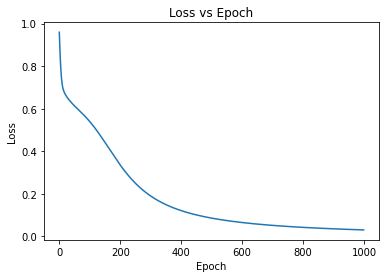

In [71]:
plt.title("Loss vs Epoch")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.plot(model.history["loss"])

In [0]:
# same dummy data as we used before
X = np.array([[1, 1], [1, 0], [0, 1], [0, 0]]).T
Y = np.array([0, 1, 1, 0])

# number of units in a hidden layer
unit_numbers = [1, 2, 3, 4, 5, 10, 20, 50, 100]

# try each number of hidden units in the for loop and
# print the accuracy for each one
# epoch is defined as 1000
for n_hidden_units in unit_numbers:

  model = MyModel(0.1)

  layer_1 = Layer(units=n_hidden_units, input_shape=(2, 1), activation="tanh")
  layer_2 = Layer(units=1, activation="sigmoid")

  model.add_layer(layer_1)
  model.add_layer(layer_2)

  model.fit(X, Y, epochs=1000, verbose=False)

  predictions = model.predict(X)

  accuracy = float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)

  print("Accuracy for {} hidden units: {}%".format(n_hidden_units, accuracy))

Accuracy for 1 hidden units: 66.16058159748553%
Accuracy for 2 hidden units: 97.02922579728171%
Accuracy for 3 hidden units: 96.5205345303777%
Accuracy for 4 hidden units: 96.63291050169838%
Accuracy for 5 hidden units: 96.49812711822749%
Accuracy for 10 hidden units: 96.105484108208%
Accuracy for 20 hidden units: 96.60991405851951%
Accuracy for 50 hidden units: 96.85797035549724%
Accuracy for 100 hidden units: 98.68565859730916%


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in log
